# NLP Project - John-Baptist, Lovely & Nico

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import string
import torch
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score
from pandas.tseries.holiday import USFederalHolidayCalendar
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModel
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. DATA LOADING AND INITIAL EXPLORATION

In [2]:
data = pd.read_csv('train_data.csv')
validation_real = pd.read_csv('test_data_no_labels.csv')
validation = validation_real.copy()

print("Dataset shape:", data.shape)
print("\nLabel distribution (0=fake, 1=real):")
print(data.label.value_counts())
print("\nSubject distribution:")
print(data.subject.value_counts())

# Convert date column
data['date'] = pd.to_datetime(data['date'], errors='coerce')
data = data.dropna(subset=['date']).sort_values('date').reset_index(drop=True)
validation['date'] = pd.to_datetime(validation['date'], errors='coerce')


print(f"\nDate range: {data['date'].min()} to {data['date'].max()}")

Dataset shape: (40399, 5)

Label distribution (0=fake, 1=real):
label
0    22787
1    17612
Name: count, dtype: int64

Subject distribution:
subject
politicsNews       10683
News                8967
worldnews           6929
politics            6478
left-news           4281
Government News     1552
US_News              757
Middle-east          752
Name: count, dtype: int64

Date range: 2015-03-31 00:00:00 to 2017-11-17 00:00:00


## 2. FEATURE ENGINEERING

In [3]:
# Extract basic time features for both datasets
for df in [data, validation]:
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day_of_week'] = df['date'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    df['days_since_start'] = (df['date'] - data['date'].min()).dt.days

In [4]:
for df in [data, validation]:
    df['caps_count'] = df['text'].apply(lambda x: sum(1 for c in x if c.isupper()))
    df['title_caps_count'] = df['title'].apply(lambda x: sum(1 for c in x if c.isupper()))
    df['punctuation_count'] = df['text'].apply(lambda x: sum(1 for c in x if c in string.punctuation))
    df['title_punctuation_count'] = df['title'].apply(lambda x: sum(1 for c in x if c in string.punctuation))

In [5]:
# Holiday and election features
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=data['date'].min(), end=data['date'].max())
data['is_holiday'] = data['date'].isin(holidays).astype(int)
validation_holidays = cal.holidays(start=validation['date'].min(), end=validation['date'].max())
validation['is_holiday'] = validation['date'].isin(validation_holidays).astype(int)

for df in [data, validation]:
    df['is_election_season'] = ((df['month'].isin([9, 10])) & (df['year'] % 2 == 0)).astype(int)

## 3. VISUALIZATIONS

C:\Users\nicol\AppData\Local\Temp\ipykernel_3044\4056724153.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0,1].set_xticklabels(['Fake (0)', 'Real (1)'])


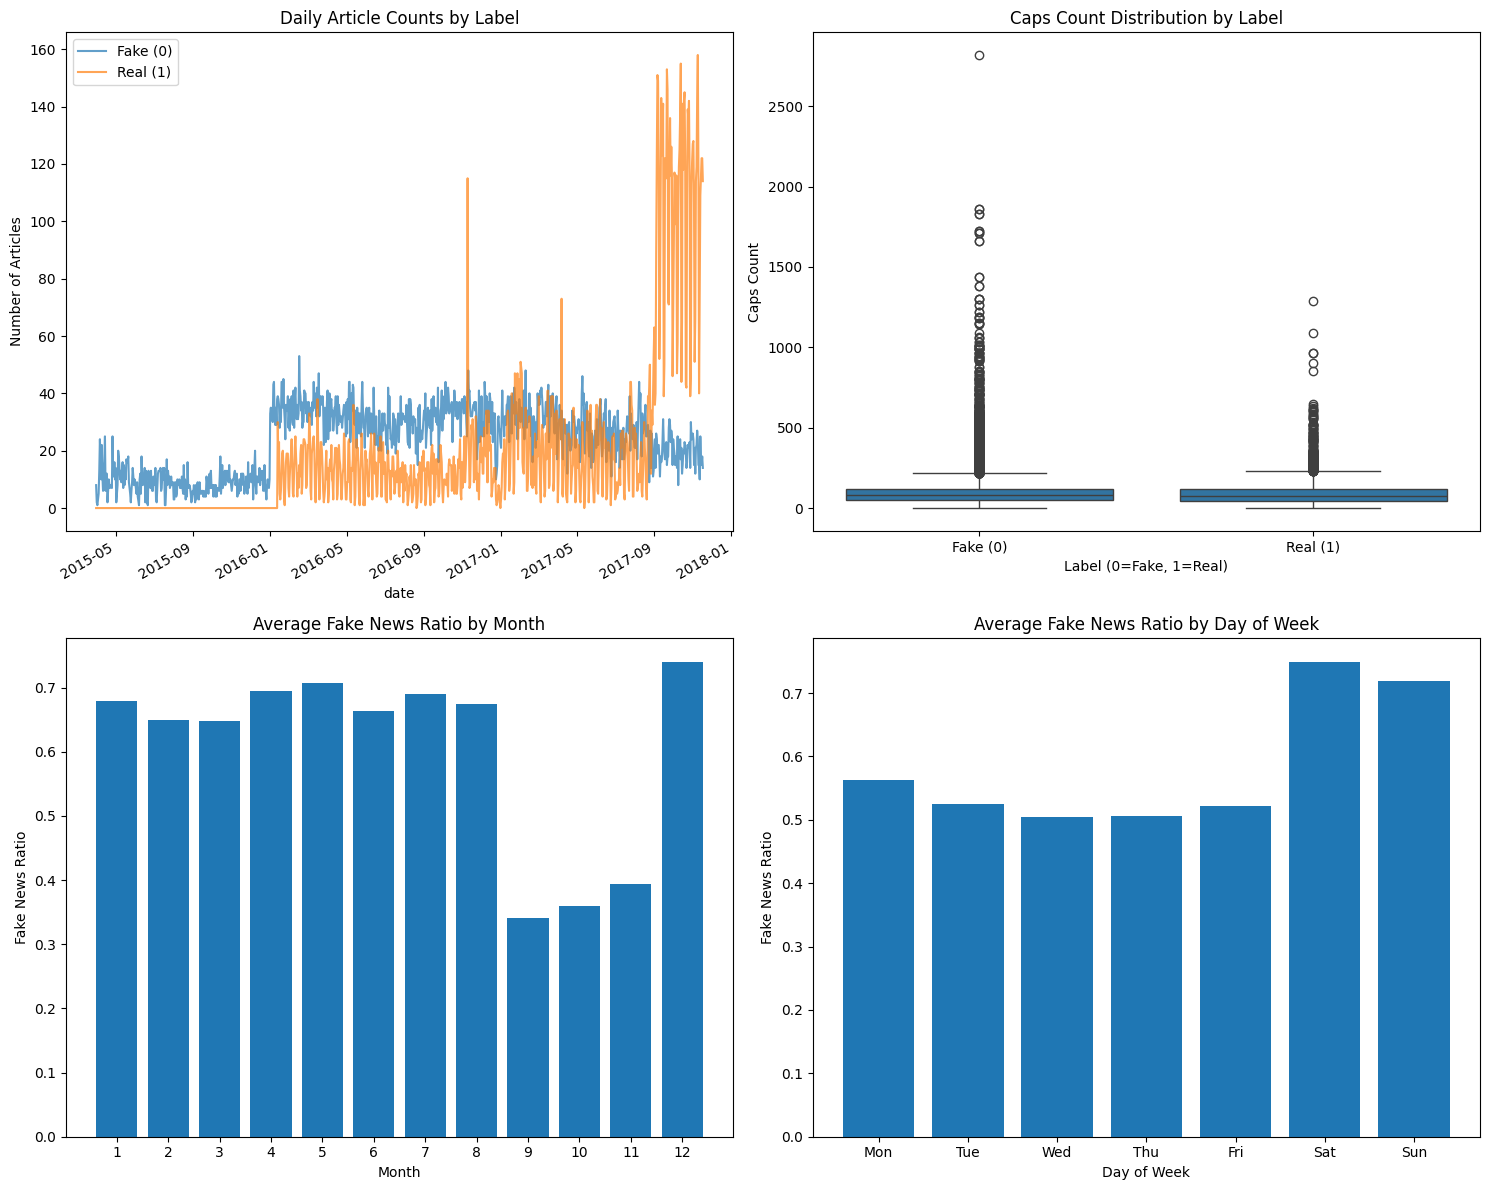

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
# Plot 1: Article counts over time by label
daily_counts = data.groupby(['date', 'label']).size().unstack(fill_value=0)
daily_counts.plot(ax=axes[0,0], alpha=0.7)
axes[0,0].set_title('Daily Article Counts by Label')
axes[0,0].set_ylabel('Number of Articles')
axes[0,0].legend(['Fake (0)', 'Real (1)'])

# Plot 2: Caps count distribution by label
sns.boxplot(x='label', y='caps_count', data=data, ax=axes[0,1])
axes[0,1].set_title('Caps Count Distribution by Label')
axes[0,1].set_xlabel('Label (0=Fake, 1=Real)')
axes[0,1].set_ylabel('Caps Count')
axes[0,1].set_xticklabels(['Fake (0)', 'Real (1)'])

# Plot 3: Monthly pattern
monthly_fake_ratio = data.groupby('month')['label'].apply(lambda x: (x == 0).mean())
axes[1,0].bar(monthly_fake_ratio.index, monthly_fake_ratio.values)
axes[1,0].set_title('Average Fake News Ratio by Month')
axes[1,0].set_xlabel('Month')
axes[1,0].set_ylabel('Fake News Ratio')
axes[1,0].set_xticks(range(1, 13))

# Plot 4: Day of week pattern
dow_fake_ratio = data.groupby('day_of_week')['label'].apply(lambda x: (x == 0).mean())
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[1,1].bar(range(7), dow_fake_ratio.values)
axes[1,1].set_title('Average Fake News Ratio by Day of Week')
axes[1,1].set_xlabel('Day of Week')
axes[1,1].set_ylabel('Fake News Ratio')
axes[1,1].set_xticks(range(7))
axes[1,1].set_xticklabels(days)

plt.tight_layout()
plt.show()

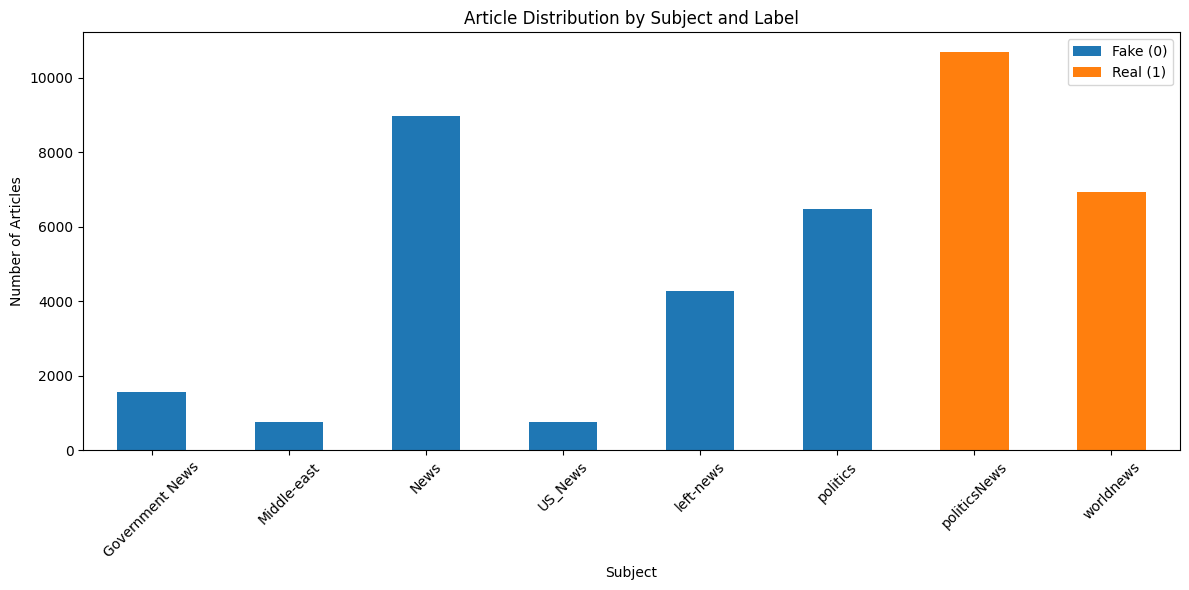

In [7]:
# Subject distribution visualization
plt.figure(figsize=(12, 6))
subject_counts = data.groupby(['subject', 'label']).size().unstack(fill_value=0)
subject_counts.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Article Distribution by Subject and Label')
plt.xlabel('Subject')
plt.ylabel('Number of Articles')
plt.legend(['Fake (0)', 'Real (1)'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

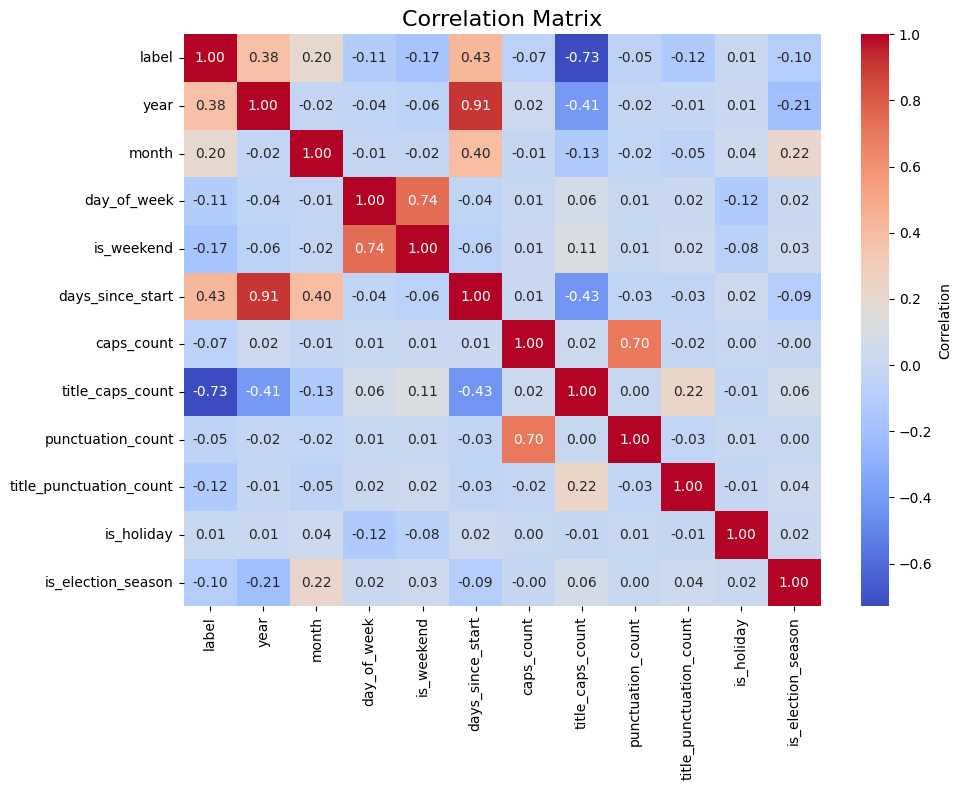

In [8]:
# Correlation matrix heatmap
numeric_df = data.select_dtypes(include=['number'])
corr_matrix = numeric_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Correlation'})
plt.title("Correlation Matrix", fontsize=16)
plt.tight_layout()
plt.show()

## 4. TEXT PREPROCESSING

In [9]:
def clean_text(text):
    """Comprehensive text cleaning function"""
    text = re.sub(r'<style[^>]*>.*?</style>', '', text, flags=re.DOTALL)
    text = re.sub(r'<script[^>]*>.*?</script>', '', text, flags=re.DOTALL)
    text = re.sub(r'', '', text, flags=re.DOTALL)
    text = re.sub(r'<[^>]*>', '', text)
    text = text.lower()
    text = re.sub(r"b['|\"](.*?)['|\"]", r'\1', text)
    text = text.lstrip('b')
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = ' '.join([word for word in text.split() if len(word) > 1])
    text = re.sub(r'[\'\"^]', '', text)
    text = re.sub(r'\.\.\.', '', text)
    return text

In [10]:
lemmatizer = WordNetLemmatizer()
def preprocess_text(df, column):
    """Applies cleaning, stopword removal, and lemmatization to a column."""
    stop_words = set(stopwords.words('english'))

    df[column] = df[column].apply(clean_text)
    df[column] = df[column].apply(word_tokenize)
    df[column] = df[column].apply(lambda tokens: [word for word in tokens if word not in stop_words])
    df[column] = df[column].apply(lambda tokens: [lemmatizer.lemmatize(word) for word in tokens])
    df[column] = df[column].apply(lambda tokens: ' '.join(tokens))
    df[column] = df[column].replace('', f'empty_{column}')

In [11]:
# Apply preprocessing to both datasets
preprocess_text(data, 'text')
preprocess_text(data, 'title')
preprocess_text(validation, 'text')
preprocess_text(validation, 'title')

### cleaned datasets

In [12]:
data.to_csv('train_data_cleaned.csv', index=False)
validation.to_csv('validation_data_cleaned.csv', index=False)

In [13]:
data

,label,title,text,subject,date,year,month,day_of_week,is_weekend,days_since_start,caps_count,title_caps_count,punctuation_count,title_punctuation_count,is_holiday,is_election_season
0,0,hillary rodham nixon candidate baggage samsoni...,irony lost u hillary compared president wanted...,politics,2015-03-31,2015,3,1,0,0,56,64,37,1,0,0
1,0,watch dirty harry reid lie romney ’ tax “ ’ win ”,case missed sen harry reid rnv announced last ...,left-news,2015-03-31,2015,3,1,0,0,32,59,23,3,0,0
2,0,hillary rodham nixon candidate baggage samsoni...,irony lost u hillary compared president wanted...,left-news,2015-03-31,2015,3,1,0,0,56,64,37,1,0,0
3,0,flashback king obama commute sentence drug dealer,making room hillary president obama today anno...,politics,2015-03-31,2015,3,1,0,0,412,48,346,1,0,0
4,0,enghazi panel call hillary testify oath white ...,anyone really think hillary clinton come clean...,politics,2015-03-31,2015,3,1,0,0,145,93,54,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40394,1,german coalition talk delayed friday source,erlin reuters talk forming new threeway german...,worldnews,2017-11-17,2017,11,4,0,962,27,2,19,1,0,0
40395,1,china minister warns seduction value western n...,eijing reuters western country trying push cul...,worldnews,2017-11-17,2017,11,4,0,962,47,2,43,0,0,0
40396,1,u say take step cambodia dissolve opposition p...,washington reuters united state expressed grav...,worldnews,2017-11-17,2017,11,4,0,962,28,3,8,3,0,0
40397,1,education sought eu help build european identity,gothenburg sweden reuters european union leade...,worldnews,2017-11-17,2017,11,4,0,962,94,4,72,0,0,0


## 5. MODEL TRAINING & EVALUATION WITH TIME SERIES CROSS-VALIDATION

In [14]:
# Prepare target variable
y = data["label"].copy()
tscv = TimeSeriesSplit(n_splits=5)

def evaluate_models(feature_combinations):
    """Evaluate multiple models with different feature combinations and vectorizers"""
    results = []
    vectorizers = [
        ("TF-IDF", TfidfVectorizer(max_features=25000, ngram_range=(1, 2))),
        ("Bag-of-Words", CountVectorizer(max_features=25000, ngram_range=(1, 2)))
    ]
    models = [
        ("Logistic Regression", LogisticRegression(max_iter=1000)),
        ("Naive Bayes", MultinomialNB()),
        ("Random Forest", RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
    ]

    for feature_name, X_text in feature_combinations.items():
        print(f"\n{'='*50}")
        print(f"Evaluating feature: {feature_name.upper()}")
        print(f"{'='*50}")
        for vec_name, vectorizer in vectorizers:
            print(f"\n--- Vectorizer: {vec_name} ---")
            for model_name, model in models:
                fold_scores = []
                print(f"Model: {model_name}")
                for fold, (train_idx, test_idx) in enumerate(tscv.split(X_text)):
                    X_train_text, X_test_text = X_text.iloc[train_idx], X_text.iloc[test_idx]
                    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
                    X_train = vectorizer.fit_transform(X_train_text)
                    X_test = vectorizer.transform(X_test_text)
                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_test)
                    accuracy = accuracy_score(y_test, y_pred)
                    fold_scores.append(accuracy)
                    print(f"  Fold {fold+1}: {accuracy:.4f}")

                avg_score = np.mean(fold_scores)
                std_score = np.std(fold_scores)
                print(f"  Average: {avg_score:.4f} (+/- {std_score:.4f})")
                results.append({
                    'Feature': feature_name,
                    'Vectorizer': vec_name,
                    'Model': model_name,
                    'Mean_Accuracy': avg_score,
                    'Std_Accuracy': std_score,
                    'Fold_Scores': fold_scores
                })
    return pd.DataFrame(results)

In [15]:
# Run evaluation
feature_combinations = {
    'text': data['text'],
    'title': data['title'],
    'text+title': data['text'] + ' ' + data['title']
}
results_df = evaluate_models(feature_combinations)


Evaluating feature: TEXT

--- Vectorizer: TF-IDF ---
Model: Logistic Regression
  Fold 1: 0.9217
  Fold 2: 0.9663
  Fold 3: 0.9748
  Fold 4: 0.9329
  Fold 5: 0.9816
  Average: 0.9554 (+/- 0.0237)
Model: Naive Bayes
  Fold 1: 0.8034
  Fold 2: 0.9344
  Fold 3: 0.9507
  Fold 4: 0.8902
  Fold 5: 0.9580
  Average: 0.9073 (+/- 0.0571)
Model: Random Forest
  Fold 1: 0.9641
  Fold 2: 0.9828
  Fold 3: 0.9886
  Fold 4: 0.9531
  Fold 5: 0.9951
  Average: 0.9767 (+/- 0.0157)

--- Vectorizer: Bag-of-Words ---
Model: Logistic Regression
  Fold 1: 0.9816
  Fold 2: 0.9889
  Fold 3: 0.9911
  Fold 4: 0.9878
  Fold 5: 0.9957
  Average: 0.9890 (+/- 0.0046)
Model: Naive Bayes
  Fold 1: 0.9458
  Fold 2: 0.9390
  Fold 3: 0.9488
  Fold 4: 0.9140
  Fold 5: 0.9655
  Average: 0.9426 (+/- 0.0168)
Model: Random Forest
  Fold 1: 0.9638
  Fold 2: 0.9750
  Fold 3: 0.9878
  Fold 4: 0.9480
  Fold 5: 0.9947
  Average: 0.9739 (+/- 0.0167)

Evaluating feature: TITLE

--- Vectorizer: TF-IDF ---
Model: Logistic Regression


In [16]:
# Print best configurations
best_configs = results_df.loc[results_df.groupby(['Vectorizer', 'Model'])['Mean_Accuracy'].idxmax()]
best_configs = best_configs.sort_values(by='Mean_Accuracy', ascending=False)
print("\nBest configurations for each vectorizer and model:")
print(best_configs[['Vectorizer', 'Model', 'Feature', 'Mean_Accuracy', 'Std_Accuracy']])


Best configurations for each vectorizer and model:
      Vectorizer                Model     Feature  Mean_Accuracy  Std_Accuracy
15  Bag-of-Words  Logistic Regression  text+title       0.989039      0.004646
14        TF-IDF        Random Forest  text+title       0.979920      0.014583
17  Bag-of-Words        Random Forest  text+title       0.979652      0.013773
12        TF-IDF  Logistic Regression  text+title       0.955978      0.025366
16  Bag-of-Words          Naive Bayes  text+title       0.946235      0.016576
13        TF-IDF          Naive Bayes  text+title       0.909550      0.057539


## 6. RESULTS VISUALIZATION

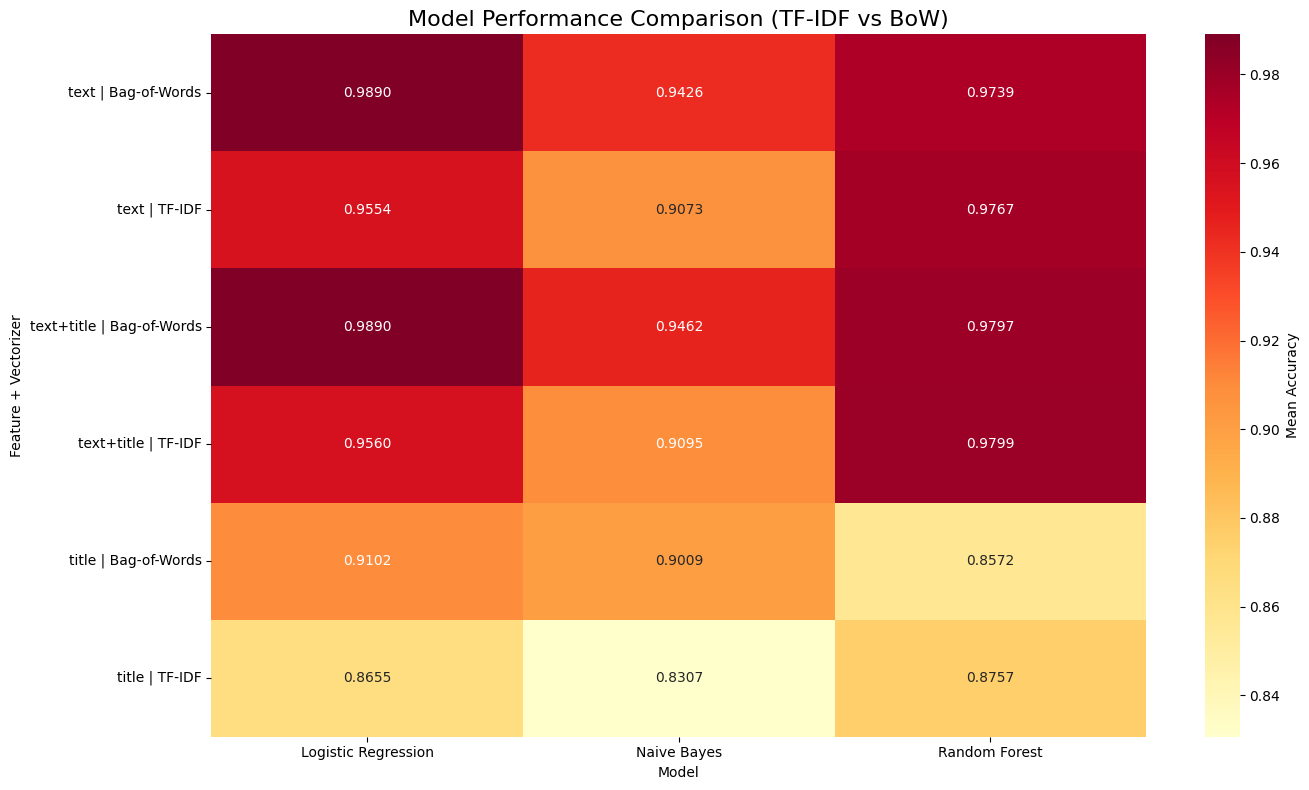

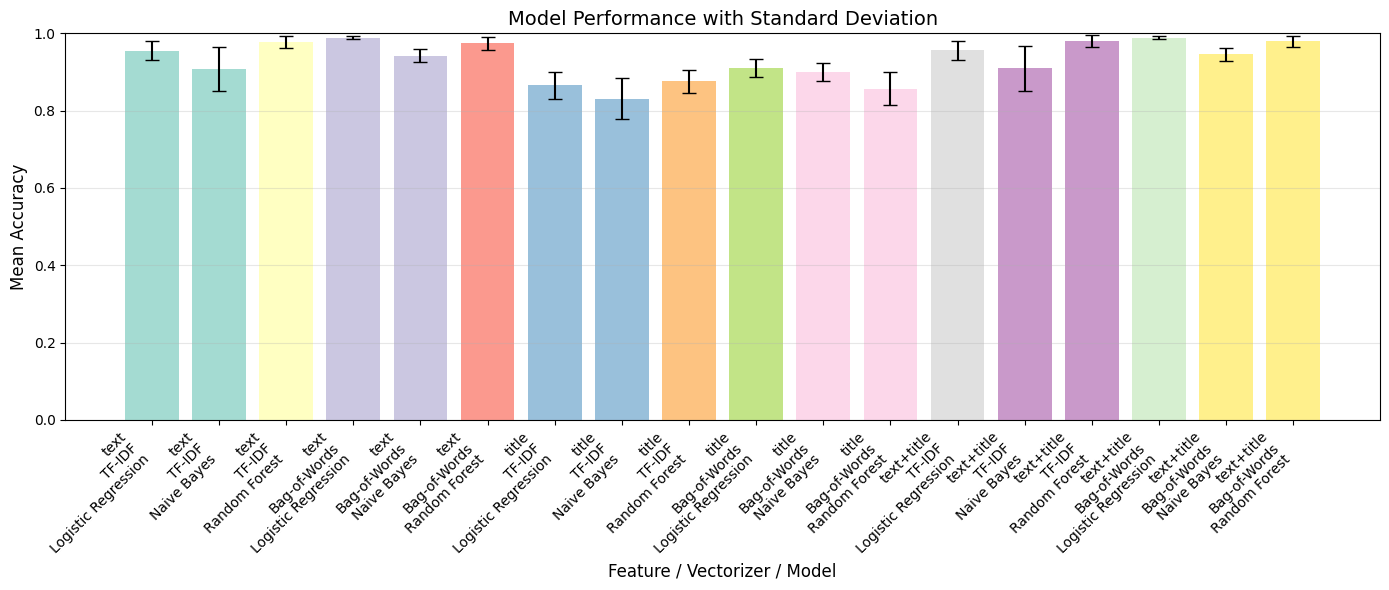

In [17]:
results_df['Feature+Vectorizer'] = results_df['Feature'] + " | " + results_df['Vectorizer']

# Heatmap: Model Performance Comparison
plt.figure(figsize=(14, 8))
pivot_results = results_df.pivot(index='Feature+Vectorizer', columns='Model', values='Mean_Accuracy')
sns.heatmap(pivot_results, annot=True, fmt='.4f', cmap='YlOrRd', cbar_kws={'label': 'Mean Accuracy'})
plt.title('Model Performance Comparison (TF-IDF vs BoW)', fontsize=16)
plt.xlabel('Model')
plt.ylabel('Feature + Vectorizer')
plt.tight_layout()
plt.show()

# Bar plot: Performance with Standard Deviation
plt.figure(figsize=(14, 6))
x_pos = np.arange(len(results_df))
colors = plt.cm.Set3(np.linspace(0, 1, len(results_df)))
plt.bar(x_pos, results_df['Mean_Accuracy'], yerr=results_df['Std_Accuracy'],
        capsize=5, color=colors, alpha=0.8)

plt.xlabel('Feature / Vectorizer / Model', fontsize=12)
plt.ylabel('Mean Accuracy', fontsize=12)
plt.title('Model Performance with Standard Deviation', fontsize=14)
plt.xticks(x_pos, [f"{row['Feature']}\n{row['Vectorizer']}\n{row['Model']}"
                    for _, row in results_df.iterrows()],
           rotation=45, ha='right')
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

text + title with bow_vectorizer and linear regression had the best performance on our test dataset

## 7. Final Prediction with the Best Classical Model

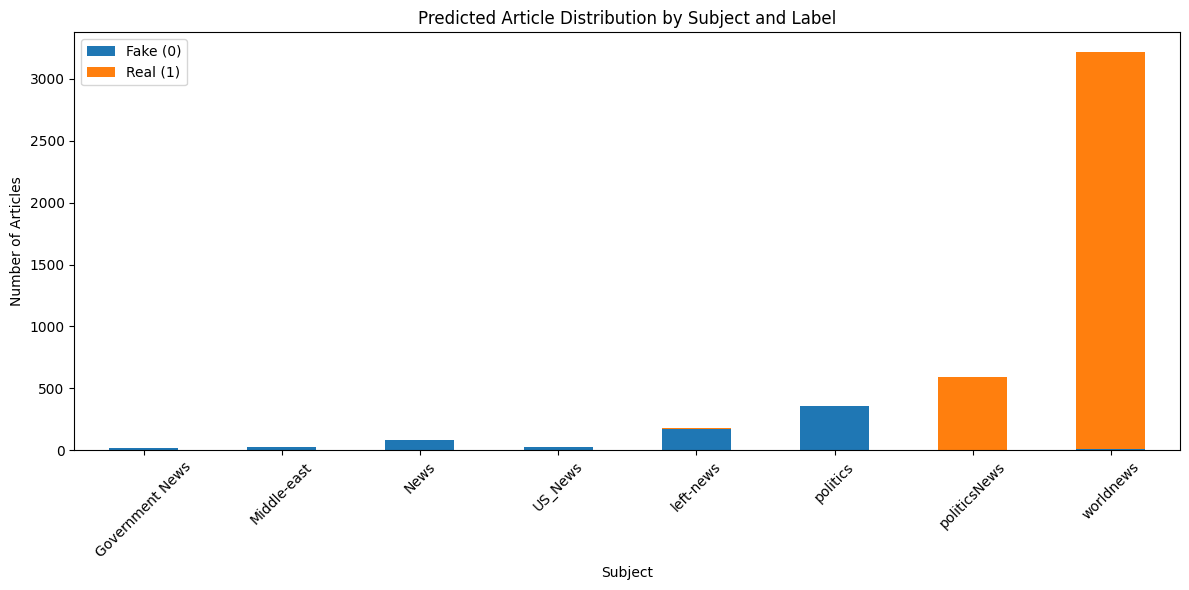

In [18]:
# The best configuration found was Logistic Regression with Bag-of-Words on text + title.
X_text = data['text'] + ' ' + data['title']
final_vectorizer = CountVectorizer(max_features=25000, ngram_range=(1, 2))
X_final_vec = final_vectorizer.fit_transform(X_text)

final_model = LogisticRegression(max_iter=1000, random_state=42)
final_model.fit(X_final_vec, y)

# Predict on the validation dataset
X_val_text = validation['text'] + ' ' + validation['title']
X_val_vec = final_vectorizer.transform(X_val_text)
val_preds = final_model.predict(X_val_vec)
validation_real['label'] = val_preds

# Visualize predictions on validation data
plt.figure(figsize=(12, 6))
subject_counts_val = validation_real.groupby(['subject', 'label']).size().unstack(fill_value=0)
subject_counts_val.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Predicted Article Distribution by Subject and Label')
plt.xlabel('Subject')
plt.ylabel('Number of Articles')
plt.legend(['Fake (0)', 'Real (1)'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

confident in our predictions based on the subject

## 8. Deliverables

In [19]:
# Save to CSV
validation_real.to_csv('test_data_with_labels.csv', index=False)

## 9. Extras - LSTM Model

In [20]:
# Combine text and title
texts = (data['text'] + ' ' + data['title']).tolist()
labels = data['label'].values

# Tokenize and pad sequences
max_words = 10000
max_length = 50
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
X_seq = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

# Build and compile the LSTM model
embedding_dim = 200
model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_length),
    LSTM(128),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Train the model
X_train, X_val, y_train, y_val = train_test_split(X_seq, labels, test_size=0.2, random_state=42)
history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val)
)

print("Model training complete.")

Epoch 1/10
1010/1010 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9519 - loss: 0.1547 - val_accuracy: 0.9797 - val_loss: 0.0881
Epoch 2/10
1010/1010 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9850 - loss: 0.0582 - val_accuracy: 0.9974 - val_loss: 0.0091
Epoch 3/10
1010/1010 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9985 - loss: 0.0063 - val_accuracy: 0.9991 - val_loss: 0.0041
Epoch 4/10
1010/1010 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9989 - loss: 0.0046 - val_accuracy: 0.9986 - val_loss: 0.0038
Epoch 5/10
1010/1010 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9996 - loss: 0.0020 - val_accuracy: 0.9993 - val_loss: 0.0036
Epoch 6/10
1010/1010 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9995 - loss: 0.0021 - val_accuracy: 0.9989 - val_loss: 0.0045
Epoch 7/10
1010/1010 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.9999 - loss: 6.6995e-04 - val_accuracy: 0.9991 - val_loss: 0.0055
Epoch 8/10
1010/1010 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 1.0000 - loss: 3.68

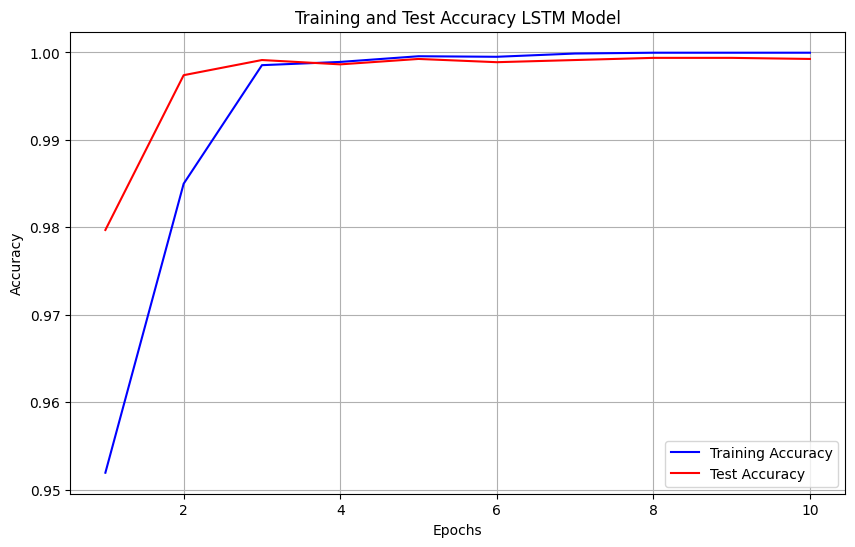

253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
--- Classification Report for Test Data ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4586
           1       1.00      1.00      1.00      3494

    accuracy                           1.00      8080
   macro avg       1.00      1.00      1.00      8080
weighted avg       1.00      1.00      1.00      8080



In [22]:
# Plot training and validation accuracy
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Test Accuracy')
plt.title('Training and Test Accuracy LSTM Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the LSTM model
predictions_prob = model.predict(X_val)
predictions_labels = (predictions_prob > 0.5).astype(int)
report = classification_report(y_val, predictions_labels)
print("--- Classification Report for Test Data ---")
print(report)

In [23]:
# Make final predictions on the validation set using the LSTM model
validation_texts = (validation_real['text'] + ' ' + validation_real['title']).tolist()
validation_sequences = tokenizer.texts_to_sequences(validation_texts)
X_val_seq = pad_sequences(validation_sequences, maxlen=max_length, padding='post', truncating='post')
predictions_prob_lstm = model.predict(X_val_seq)
predictions_labels_lstm = (predictions_prob_lstm > 0.5).astype(int)
validation_real['label_lstm'] = predictions_labels_lstm.flatten()

# Save final predictions
validation_real.to_csv('test_data_with_labels_LSTM.csv', index=False)
print("Predictions for the full validation set are complete and saved.")

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Predictions for the full validation set are complete and saved.


In [26]:
#compare the label in "test_labels.csv" with my predicted labels in test_data_with_labels_LSTM.csv and give scores 
test_labels = pd.read_csv('test_labels.csv')
predicted_labels_LSTM = validation_real['label_lstm']
accuracy = accuracy_score(test_labels['label'], predicted_labels_LSTM)
f1 = f1_score(test_labels['label'], predicted_labels_LSTM)
print(f"Accuracy of LSTM model on test data: {accuracy:.4f}")
print(f"F1 Score of LSTM model on test data: {f1:.4f}")
#same for "test_data_with_labels.csv
test_labels_bow = pd.read_csv('test_labels.csv')
predicted_labels_bow = validation_real['label']
accuracy_bow = accuracy_score(test_labels_bow['label'], predicted_labels_bow)
f1_bow = f1_score(test_labels_bow['label'], predicted_labels_bow)
print(f"Accuracy of BoW model on test data: {accuracy_bow:.4f}")
print(f"F1 Score of BoW model on test data: {f1_bow:.4f}")


Accuracy of LSTM model on test data: 0.9664
F1 Score of LSTM model on test data: 0.9798
Accuracy of BoW model on test data: 0.9973
F1 Score of BoW model on test data: 0.9984
